<a href="https://colab.research.google.com/github/antonysama/Projects_w._time_series/blob/master/Fisheries_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install feature-engine

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model and cross val and gridsearch
from sklearn.model_selection import (
    KFold,
    RepeatedKFold,
    LeaveOneOut,
    LeavePOut,
    StratifiedKFold,
    GridSearchCV,
    train_test_split,
)
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
# other regressors: https://www.educative.io/blog/scikit-learn-cheat-sheet-classification-regression-methods
from sklearn.pipeline import Pipeline
from sklearn.metrics import  r2_score
pd.pandas.set_option('display.max_columns', None)

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import (imputation as mdi, discretisation as dsc, encoding as ce)
import scipy.stats as stats
import feature_engine.transformation as vt
from feature_engine.outliers import Winsorizer




In [ ]:
# load dataset
fields = ['GEAR_NME','LICENCE_AREA','Vessel ID Number','GEAR_CDE','Nominal_Value','KG_PIECE','Nominal_PRICE_PIECE']
data=pd.read_csv('drive/MyDrive/q2.csv', error_bad_lines=False,usecols=fields)
# data=pd.read_csv('q2.csv', error_bad_lines=False)

print(data.shape)
data.head(2)

(566739, 7)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,GEAR_NME,LICENCE_AREA,Vessel ID Number,GEAR_CDE,KG_PIECE,Nominal_PRICE_PIECE,Nominal_Value
0,SEINE,SALMON AREA B,4856,20,4.391591,8.540229,227298.1995
1,SEINE,SALMON AREA B,3980,20,4.595482,8.611520,215287.9969


In [ ]:
# Disaggregate date 
data[["month", "day", "year"]] = data["DATE"].str.split("/", expand = True)
data.drop(['DATE'], axis=1 , inplace=True) # nex time, don't drop 'day'
data.head(2)


In [ ]:
data.isnull().mean()

GEAR_NME               0.0
LICENCE_AREA           0.0
Vessel ID Number       0.0
GEAR_CDE               0.0
KG_PIECE               0.0
Nominal_PRICE_PIECE    0.0
Nominal_Value          0.0
dtype: float64

In [ ]:
# Inspected the type of variables in pandas, and changed as appropriate
for col in ['GEAR_CDE']:
    data[col] = data[col].astype(object)
# for col in ['month','day','year']:
#     data[col] = data[col].astype(int)
data.dtypes

GEAR_NME                object
LICENCE_AREA            object
Vessel ID Number        object
GEAR_CDE                object
KG_PIECE               float64
Nominal_PRICE_PIECE    float64
Nominal_Value          float64
dtype: object

In [ ]:
# find categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

There are 4 categorical variables


In [ ]:
# make a list of the numerical variables first
numerical = [var for var in data.columns if data[var].dtype!='O']

# list of variables that contain temporal information
# temporal_vars = [var for var in categorical if 'month' in var or 'year' in var or 'day' in var]

numerical #, temporal_vars

['KG_PIECE', 'Nominal_PRICE_PIECE', 'Nominal_Value']

Text(0, 0.5, 'Nominal value')

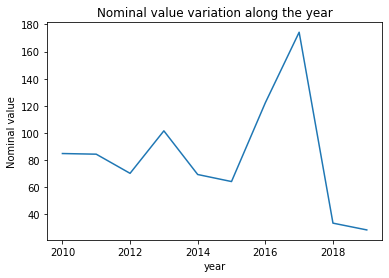

In [ ]:
# plot nominal value per month or year

data.groupby('year')['Nominal_Value'].median().plot()
plt.title('Nominal value variation along the year')
plt.ylabel('Nominal value')

In [ ]:
# tabulate nominal value per species or other catefory
data.groupby('year')['Nominal_Value'].median().reset_index()
# data.groupby('year')['Nominal_Value'].median().sort_values(ascending=False).reset_index() # to order by nominal value

,year,Nominal_Value
0,2010,84.785689
1,2011,84.307003
2,2012,70.178571
3,2013,101.522777
4,2014,69.314292
5,2015,64.121179
6,2016,122.234509
7,2017,174.259378
8,2018,33.437152
9,2019,28.439915


In [ ]:
# let's visualise the values of the discrete variables
discrete = []

for var in numerical:
    if len(data[var].unique()) < 35:
        print(var, ' values: ', data[var].unique())
        discrete.append(var)
print()
print('There are {} discrete variables'.format(len(discrete)))


There are 0 discrete variables


In [ ]:
# find continuous variables
# skip the target and correlated vars
continuous = [var for var in numerical if var not in discrete  
              and var not in ['Nominal_Value']]

print('There are {}  continuous variables :  '.format(len(continuous))), print(continuous)

There are 2  continuous variables :  
['KG_PIECE', 'Nominal_PRICE_PIECE']


(None, None)

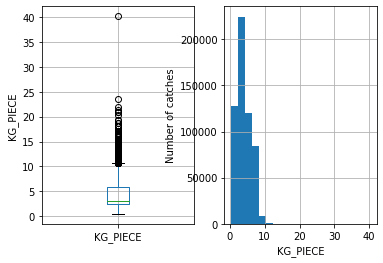

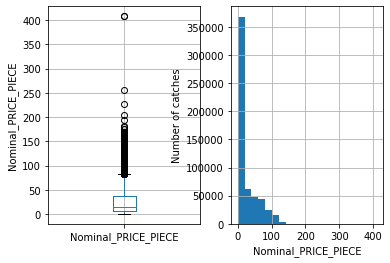

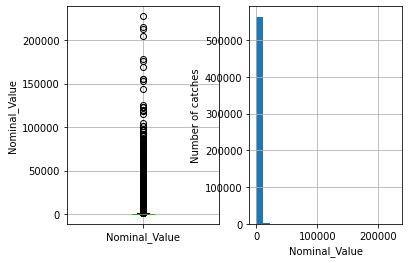

In [ ]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in numerical:
    plt.figure(figsize=(6,4))
    plt.subplot(1, 2, 1)
    fig = data.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = data[var].hist(bins=20)
    fig.set_ylabel('Number of catches')
    fig.set_xlabel(var)

    plt.show()

Text(0, 0.5, 'Number of different categories')

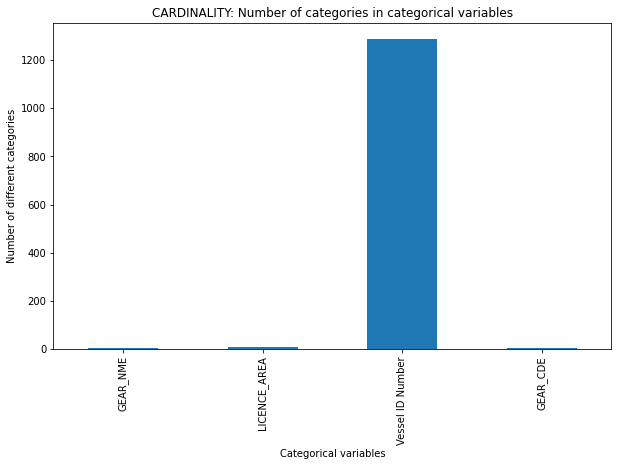

In [ ]:
# plot number of categories per categorical variable

data[categorical].nunique().plot.bar(figsize=(10,6))
plt.title('CARDINALITY: Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

In [ ]:
# Let's separate into train and test set
# inlcude the target varfiable in X and Y

X_train, X_test, y_train, y_test = train_test_split(data.drop('Nominal_Value', axis=1),
                                                    data['Nominal_Value'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape

((510065, 6), (56674, 6))

In [ ]:
fisheries_pipe = Pipeline([
    # categorical encoding - section 6
    ('rare_label_enc', ce.RareLabelEncoder(
        tol=0.05, n_categories=6, variables=categorical)), 
    
    ('categorical_enc', ce.OrdinalEncoder(
        encoding_method='ordered', variables=categorical)), # can try 'arbitrary' or 'ordered'

    #  # transform - SECTION 7   # didn't increase R2
     ('lt', vt.LogTransformer(variables = continuous+discrete)), # a.k.a 'continuous

    # discretisation + encoding - section 8
    ('discretisation', dsc.EqualFrequencyDiscretiser(
        q=5, return_object=True, variables=continuous+discrete)),
      
    ('encoding', ce.OrdinalEncoder(
        encoding_method='ordered', variables=continuous+discrete)),

    # # outlier capping - sectionn 9 #didn't increase r2
    ('windsoriser', Winsorizer(
        capping_method='gaussian', tail='both', fold=3, variables=continuous+discrete)),

    # feature Scaling - section 10
    ('scaler', StandardScaler()),
    
    # regression
    # ('classifier', LGBMRegressor(random_state=10)) # best are LGBMRegressor, RandomForestRegressor
    ('classifier', RandomForestRegressor(random_state=10))  
])

In [ ]:
# now we create the hyperparameter space that we want to sample
# to perform Grid search, we need to specifically provide the hyperparameter
param_grid = { 
    'rare_label_enc__tol': [0.1, 0.5],
    'classifier__n_estimators': [10, 300, 800],#need some others
    'classifier__max_depth': [5, 10,30, 50, None],
    'classifier__min_samples_split': [2,4,8],
    'classifier__max_depth':[3,6],
}

# # K-Fold Cross-Validation
# kf = KFold(n_splits=3, shuffle=True, random_state=10)

# search
grid_search =  GridSearchCV(
    fisheries_pipe,
    param_grid,
    scoring='r2',
    cv=5, # k-fold
    refit=True, # refits best model to entire dataset
)



In [ ]:
search=grid_search.fit(X_train, y_train)
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
print(results.shape)
results

/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:182: UserWarning: The number of unique categories for variable GEAR_NME is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:182: UserWarning: The number of unique categories for variable GEAR_CDE is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:182: UserWarning: The number of unique categories for variable GEAR_NME is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:182: UserWarning: The number of unique categories for variable GEAR_CDE is less than t

(36, 3)


,params,mean_test_score,std_test_score
0,"{'classifier__max_depth': 3, 'classifier__min_...",0.185255,0.010473
1,"{'classifier__max_depth': 3, 'classifier__min_...",0.183744,0.010291
2,"{'classifier__max_depth': 3, 'classifier__min_...",0.218651,0.010237
3,"{'classifier__max_depth': 3, 'classifier__min_...",0.213852,0.009757
4,"{'classifier__max_depth': 3, 'classifier__min_...",0.219767,0.009934
5,"{'classifier__max_depth': 3, 'classifier__min_...",0.214246,0.009575
6,"{'classifier__max_depth': 3, 'classifier__min_...",0.185255,0.010473
7,"{'classifier__max_depth': 3, 'classifier__min_...",0.183744,0.010291
8,"{'classifier__max_depth': 3, 'classifier__min_...",0.218651,0.010237
9,"{'classifier__max_depth': 3, 'classifier__min_...",0.213852,0.009757


In [ ]:
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean Accuracy')

plt.xlabel('Hyperparameter space')

In [ ]:
search.best_params_

{'classifier__max_depth': 6,
 'classifier__min_samples_split': 4,
 'classifier__n_estimators': 800,
 'rare_label_enc__tol': 0.1}

In [ ]:
%%capture
# let's fit the pipeline - two pipeline options: fisheries or grid_search

# let's get the predictions
fisheries_pipe.fit(X_train, y_train) 
X_train_preds = fisheries_pipe.predict(X_train) 
X_test_preds = fisheries_pipe.predict(X_test) 

# grid_search.fit(X_train, y_train)
# X_train_preds = grid_search.predict(X_train)
# X_test_preds = grid_search.predict(X_test)

# check model performance:
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

Text(0, 0.5, 'Predicted Price')

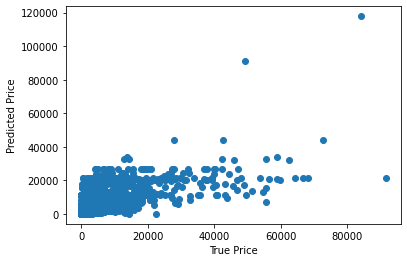

In [ ]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')

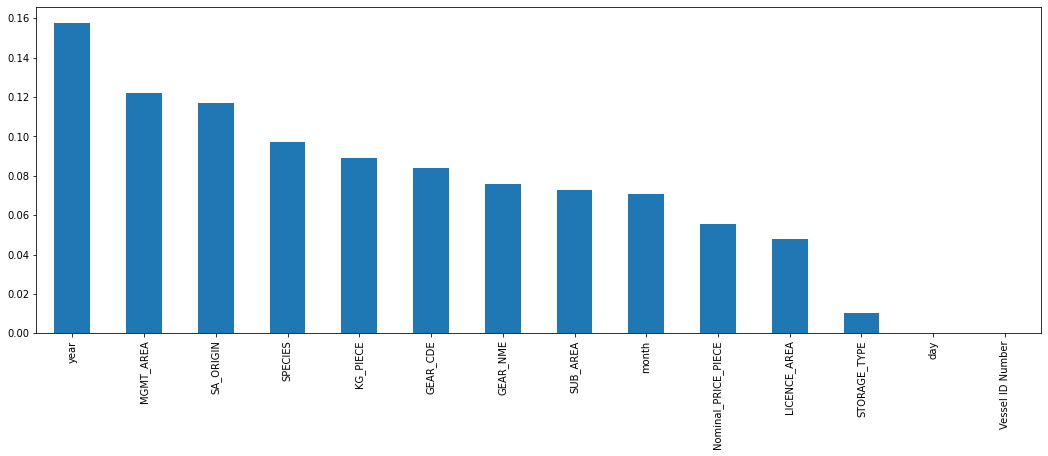

In [ ]:
# let's explore the importance of the features

importance = pd.Series(np.abs(fisheries_pipe.named_steps['classifier'].feature_importances_))
importance.index = list(X_train.columns) 
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))

In [ ]:
print(X_test_preds)

[  82.03148752 4142.27803419  387.8465399  ...   25.7546431    72.56969631
  923.37429645]


save model to predct new data https://scikit-learn.org/stable/modules/model_persistence.html https://stackoverflow.com/questions/47416982/load-and-predict-new-data-sklearn/47417363